In [1]:
import numpy as np
from matplotlib import pyplot as plt
from IPython import display

np.random.seed(0)

import torch

# which folder
folder_index = 1

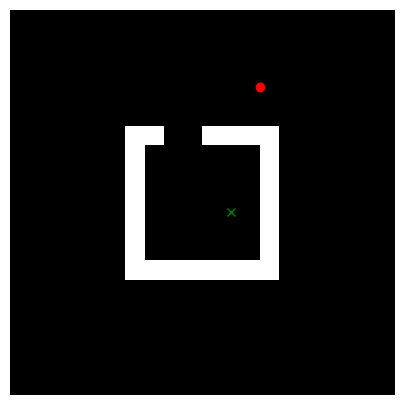

In [2]:
from grid_env import GridEnv
env = GridEnv(sparse=True)
env.plot()

The shape of the state pairs are: 
torch.Size([10000, 2, 2])
Example of a state pair: tensor([[10., 11.],
        [13., 14.]])

The shape of the preferences are: 
torch.Size([10000, 1])
The preferences are: tensor([[0.],
        [0.],
        [1.],
        ...,
        [0.],
        [1.],
        [0.]])


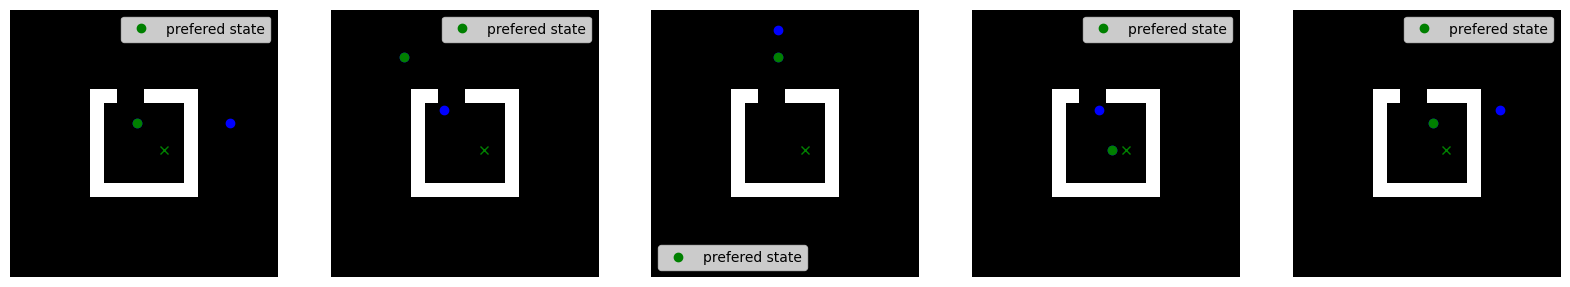

In [4]:
# load the state_pairs and preferences.pt
state_pairs = torch.load(f'world_{folder_index}/state_pairs.pt')
preferences = torch.load(f'world_{folder_index}/preferences.pt')

print("The shape of the state pairs are: \n" + str(state_pairs.size()))
print("Example of a state pair: " + str(state_pairs[0]))
print("")
print("The shape of the preferences are: \n" + str(preferences.size()))
print("The preferences are: " + str(preferences))

num_pairs = state_pairs.size()[0]
# select 5 random pairs of states, and colour the state that is prefered in green
num_plot = 5
# create subplots
fig, axs = plt.subplots(1, num_plot, figsize=(20,5))
# plot each state pair
for i in range(num_plot):
    # randomly choose a state pair
    idx = np.random.randint(num_pairs)
    s1 = state_pairs[idx,0,:]
    s2 = state_pairs[idx,1,:]
    p = preferences[idx,0]
    # plot the first state
    axs[i].imshow(env.occ_map.T, origin="lower",extent=[0,env.N,0,env.N], cmap='gray')
    axs[i].plot(env.xl+0.5,env.yl+0.5,'gx') # goal location
    axs[i].plot(s1[0]+0.5,s1[1]+0.5,'bo')
    # plot the second state
    axs[i].plot(s2[0]+0.5,s2[1]+0.5,'bo')
    # plot the prefered state in green
    if p == 0:
        axs[i].plot(s1[0]+0.5,s1[1]+0.5,'go', label='prefered state')
    else:
        axs[i].plot(s2[0]+0.5,s2[1]+0.5,'go', label='prefered state')
    # finish up the rest of the plot settings
    axs[i].legend()
    axs[i].axis('off')

In [5]:
# create dataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

class PreferenceDataset(Dataset):
    def __init__(self, state_pairs, preferences):
        self.state_pairs = state_pairs
        self.preferences = preferences

    def __getitem__(self, index):
        return self.state_pairs[index], self.preferences[index]

    def __len__(self):
        return len(self.state_pairs)

In [6]:
dataset = PreferenceDataset(state_pairs, preferences)
# split the dataset into train, validation and test
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
# create dataloaders
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

# print the shapes of batches from dataloaders
batch = next(iter(train_loader))
print("The shape of the input batch: " + str(batch[0].shape))
print("The shape of the batch labels: " + str(batch[1].shape))

The shape of the input batch: torch.Size([32, 2, 2])
The shape of the batch labels: torch.Size([32, 1])


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim

# create a preference learning model
class PreferenceModel(nn.Module):
    def __init__(self):
        super(PreferenceModel, self).__init__()
        self.fc1 = nn.Linear(1, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # apply the linear layers to each state in the state pair
        x1 = self.relu(self.fc1(x[:, 0].unsqueeze(1)))
        x1 = self.relu(self.fc2(x1))
        x1 = self.fc3(x1)
        u1 = x1[:, 0].unsqueeze(1)
        x2 = self.relu(self.fc1(x[:, 1].unsqueeze(1)))
        x2 = self.relu(self.fc2(x2))
        x2 = self.fc3(x2)
        u2 = x2[:, 0].unsqueeze(1)
        return self.sigmoid(u1 - u2)
    
    def predict_reward(self, x):
        r = self.relu(self.fc1(x[:, 0].unsqueeze(1)))
        r = self.relu(self.fc2(r))
        r = self.fc3(r)
        return r
    
# training step
def training_step(input_batch, target_batch, model, optimizer, loss_fn):
    preds = model(input_batch) # forward pass
    loss = loss_fn(preds, target_batch) # find loss
    optimizer.zero_grad() # clear gradients in the optimiser
    loss.backward() # back prop
    optimizer.step() # gradient descend
    return loss.item() # return loss

# validation step
def validation_step(input_batch, target_batch, model, loss_fn):
    preds = model(input_batch) # forward pass
    loss = loss_fn(preds, target_batch) # find loss
    return loss.item()